# Exploration of Past U.S Presidential Elections

### Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm

### Importing and manipulating 2016 Election Data

In [2]:
df = pd.read_excel ('election_results_2016.xlsx')

election_2016 = df.loc[451:517]
election_2016 = election_2016.drop(columns = ['Rpt', 'Vote by town', 'Place', 'State'])

for each in range(451,518):
    if election_2016.loc[each, 'Clinton'] > election_2016.loc[each,'Trump']:
        election_2016.loc[each, 'Classification'] = 1 #democrat
    else:
        election_2016.loc[each, 'Classification'] = 0 #republican

### Importing and manipulating 2008 Election Data

In [3]:
df2 = pd.read_excel ('election_results_2008.xlsx')

election_2008 = df2.drop(columns = ['TotalPrecincts', 'PrecinctsReporting', 'Other'])

for each in range(0,67):
    if election_2008.loc[each, 'Obama'] > election_2008.loc[each,'McCain']:
        election_2008.loc[each, 'Classification'] = 1 #democrat
    else:
        election_2008.loc[each, 'Classification'] = 0 #republican

#### Take a peek at what the original data looked like, and then what it looked like after dropping some columns, and adding a classification column:

In [4]:
# peek at what the original election data included
df.head()

,Clinton,Trump,Rpt,State,Vote by county,Vote by town,Place
0,151581,130614,100,Alabama,Jefferson,NaN,Jefferson
1,68429,91087,100,Alabama,Mobile,NaN,Mobile
2,62435,89199,100,Alabama,Madison,NaN,Madison
3,22927,72846,100,Alabama,Shelby,NaN,Shelby
4,58669,33928,100,Alabama,Montgomery,NaN,Montgomery


In [5]:
# view data after adding a classification column
election_2016.head()

,Clinton,Trump,Vote by county,Classification
451,623006,333666,Miami-Dade,1.0
452,546956,258521,Broward,1.0
453,371411,270762,Palm Beach,1.0
454,306422,265928,Hillsborough,1.0
455,329579,195091,Orange,1.0


### Importing and Manipulating Demographic Data

#### This data set included information from several years and we wanted to only include data from the years we were interested in

In [6]:
flo_demo = pd.read_excel("Florida_Demo.xlsx")

In [7]:
#including specific instances in each data set
yr_2008 = flo_demo['YEAR']==1
yr_2016 = flo_demo['YEAR']==9
yr_2018 = flo_demo['YEAR']==11
age_all = flo_demo['AGEGRP']==0

demo_2008 = flo_demo[yr_2008 & age_all]
demo_2016 = flo_demo[yr_2016 & age_all]
# demo_both = flo_demo[(yr_2016 | yr_2008) & age_all]

In [8]:
# data we will be predicting on:
demo_predict = flo_demo[yr_2018 & age_all]

In [9]:
# len(demo_predict)


## Further Manipulation of the Data: 

#### Here we are removing unnecessary columns and inconsistencies in the data (ex: "County" was spelled differently in the two data sets that we are going to merge) 

In [10]:
new_demo_2008 = pd.DataFrame(demo_2008, columns = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME',
                                                                          'YEAR','AGEGRP', 'TOT_POP', 'TOT_MALE',
                                                                            'TOT_FEMALE','BA_MALE', 'BA_FEMALE',
                                                                          'AA_MALE', 'AA_FEMALE','NH_MALE',
                                                                          'NH_FEMALE', 'H_MALE', 'H_FEMALE',
                                                                         'WA_MALE', 'WA_FEMALE'])
new_demo_2008 = new_demo_2008.reset_index()
for each in range(0,67):
    new_demo_2008.loc[each, 'CTYNAME'] = new_demo_2008.loc[each, 'CTYNAME'].replace(" County", "")

In [11]:
new_demo_2016 = pd.DataFrame(demo_2016, columns = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME',
                                                                          'YEAR','AGEGRP', 'TOT_POP', 'TOT_MALE',
                                                                            'TOT_FEMALE','BA_MALE', 'BA_FEMALE',
                                                                          'AA_MALE', 'AA_FEMALE','NH_MALE',
                                                                          'NH_FEMALE', 'H_MALE', 'H_FEMALE',
                                                                         'WA_MALE', 'WA_FEMALE'])
new_demo_2016 = new_demo_2016.reset_index()
for each in range(0,67):
    new_demo_2016.loc[each, 'CTYNAME'] = new_demo_2016.loc[each, 'CTYNAME'].replace(" County", "")

In [12]:
new_demo_predict = pd.DataFrame(demo_predict, columns = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME',
                                                                          'YEAR','AGEGRP', 'TOT_POP', 'TOT_MALE',
                                                                            'TOT_FEMALE','BA_MALE', 'BA_FEMALE',
                                                                          'AA_MALE', 'AA_FEMALE','NH_MALE',
                                                                          'NH_FEMALE', 'H_MALE', 'H_FEMALE',
                                                                         'WA_MALE', 'WA_FEMALE'])
new_demo_predict = new_demo_predict.reset_index()
for each in range(0,67):
    new_demo_predict.loc[each, 'CTYNAME'] = new_demo_predict.loc[each, 'CTYNAME'].replace(" County", "")

#### Peek at the data again: notice the last column does not include "CLASS"

In [13]:
new_demo_2008.head()
# new_demo_2016.head()
# new_demo_predict.head()

,index,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,WA_MALE,WA_FEMALE
0,0,12,1,Florida,Alachua,1,0,247336,119786,127550,23663,27135,6680,6865,109756,116828,10030,10722,86242,90127
1,209,12,3,Florida,Baker,1,0,27115,14160,12955,2286,1411,67,71,13870,12725,290,230,11601,11220
2,418,12,5,Florida,Bay,1,0,168852,83656,85196,9058,9350,1373,2068,79463,81282,4193,3914,70181,70717
3,627,12,7,Florida,Bradford,1,0,28520,16010,12510,3944,1914,62,94,15264,12236,746,274,11758,10238
4,836,12,9,Florida,Brevard,1,0,543376,266242,277134,27255,28977,4899,6842,244765,254668,21477,22466,226404,233570


## Add the "Class" column to the data aka merge the data frames

In [14]:
# Table for 2008 Data
new_demo_2008['CLASS'] = None

for each in range(0,67):
    for i in range(0,67):
        if new_demo_2008.loc[each, 'CTYNAME'] == election_2008.loc[i, 'County']:
            new_demo_2008.loc[each, 'CLASS'] = election_2008.loc[i, 'Classification']

In [15]:
# Table for 2016 Data
new_demo_2016['CLASS'] = None

for each in range(0,67):
    for i in range(451,518):
        if new_demo_2016.loc[each, 'CTYNAME'] == election_2016.loc[i, 'Vote by county']:
            new_demo_2016.loc[each, 'CLASS'] = election_2016.loc[i, 'Classification']

#### Peek at the data and notice the last column: "CLASS" is now included

In [16]:
# new_demo_2008.head()
new_demo_2016.head()

,index,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,BA_FEMALE,AA_MALE,AA_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,WA_MALE,WA_FEMALE,CLASS
0,152,12,1,Florida,Alachua,9,0,264287,127981,136306,...,29311,7879,8011,115784,123241,12197,13065,90631,94853,1
1,361,12,3,Florida,Baker,9,0,27872,14638,13234,...,1400,84,97,14251,12940,387,294,11802,11440,0
2,570,12,5,Florida,Bay,9,0,183384,91361,92023,...,10561,1697,2399,85298,86466,6063,5557,75335,75200,0
3,779,12,7,Florida,Bradford,9,0,26736,14526,12210,...,1885,81,86,13831,11881,695,329,10807,9876,0
4,988,12,9,Florida,Brevard,9,0,577338,282052,295286,...,32223,6240,8100,253914,265917,28138,29369,237305,245528,0


## Create a combined dataset with all samples (both 2008 and 2016 samples)

In [18]:
frames = [new_demo_2008, new_demo_2016]

both_data = pd.concat(frames)
both_data = both_data.reset_index()

In [19]:
# Peek at the data (still has lots of unnecessary columns)
# both_data.head()

## Visualize Class Separation

#### Here we are checking if we have a class imbalance to see how we want to separate the data

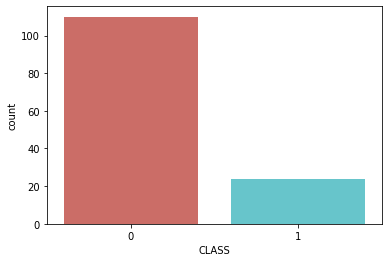

In [20]:
sns.countplot(x = 'CLASS', data = both_data, palette = 'hls')
plt.show()

## Split Data into test and train splits

#### Since we have a class imbalance we are using a stratified split when we split into train and "test" sets ("test" is truly a validation set since we have a held out set we will be using later)

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=142) #42

for train_index, test_index in split.split(both_data, both_data['CLASS']):
    train_set = both_data.loc[train_index]
    test_set = both_data.loc[test_index]

In [22]:
# Only include columns that are needed and separate the data into training and test
training_x = train_set.drop(['level_0','index','STATE','COUNTY','CTYNAME','AGEGRP','YEAR', 'STNAME','CLASS'], axis=1)
training_y = train_set[['CLASS']].copy()

testing_x = test_set.drop(['level_0','index','STATE','COUNTY','CTYNAME','AGEGRP','YEAR', 'STNAME','CLASS'], axis=1)
testing_y = test_set[['CLASS']].copy()

#### Peek at the data we will be using to train and "test"

In [87]:
training_x.head()
# training_y.head()

,TOT_POP,TOT_MALE,TOT_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,WA_MALE,WA_FEMALE
112,200260,101591,98669,10857,9469,2349,3946,92325,89933,9266,8736,83210,80214
122,305837,149568,156269,30428,32662,2473,3334,121170,128231,28398,28038,112327,115925
120,72378,35766,36612,5628,6230,203,257,32018,33211,3748,3401,29026,29213
100,334748,161915,172833,17542,19043,3247,4097,136812,148029,25103,24804,136619,144935
53,74364,36884,37480,5857,6336,191,270,33297,34361,3587,3119,30056,30058


## Exploratory analysis: Visualizing the distribution of data using one feature, with hue based on true class labels

#### Here we were just interested in how the data separated

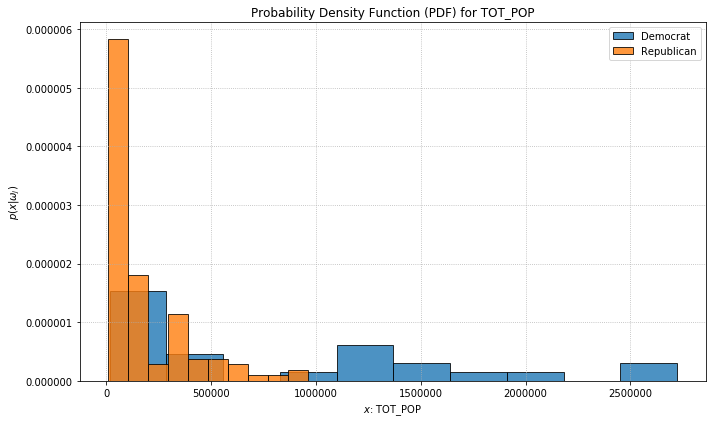

In [24]:
democrat = both_data.loc[both_data['CLASS'] == 1,:]
republican = both_data.loc[both_data['CLASS'] == 0,:]
feat_name = 'TOT_POP'
# Create the holder for the plots
f, ax = plt.subplots(figsize=(10,6))

d_counts, d_bins, _ = ax.hist(democrat[feat_name], density=True, alpha=.8, label="Democrat", bins=10, edgecolor='k')
r_counts, r_bins, _ = ax.hist(republican[feat_name], density=True, alpha=.8, label="Republican",  bins=10, edgecolor='k')

d_counts = np.append(d_counts, [0])
r_counts = np.append(r_counts, [0])

ax.set(xlabel=r'$x$: '+feat_name,
       ylabel=r'$p(x|\omega_{j})$',
       title='Probability Density Function (PDF) for '+feat_name)

ax.legend(frameon=True)
ax.grid(linestyle=':')
plt.tight_layout()

plt.show()

# Begin training and validating classifiers

## Creating a table for average accuracy

#### For each classifier we trained we found the average accuracy and added it to the table, which is shown at the end to summarize the performances of each classifier.

In [25]:
avg_accuracy = pd.DataFrame(columns = ["Classifier", "Percent_Avg_Accuracy"])
avg_accuracy.head()

,Classifier,Percent_Avg_Accuracy


## Naive Bayes Classifier

In [26]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(training_x, np.ravel(training_y))
y_pred_NB = gnb.predict(testing_x)

In [29]:
scores = cross_val_score(gnb, testing_x, np.ravel(testing_y), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Naive Bayes', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 85.83 %


## Logistic Regression Classifier


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
log_model = LogisticRegression(solver='liblinear', random_state=0)
y_pred_log = log_model.fit(training_x,np.ravel(training_y)).predict(testing_x)

In [34]:
scores = cross_val_score(log_model, testing_x, np.ravel(testing_y), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Logistic1', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 89.92 %


# After some thought we decided we should have scaled the data before creating any models, so we turned all the data into percentages and then ran the models again. 

In [35]:
norm_data = both_data.drop(['level_0','index','STATE','COUNTY','CTYNAME','AGEGRP','YEAR', 'STNAME'], axis=1)

In [36]:
norm_data[['TOT_MALE', 'TOT_FEMALE', 'BA_MALE', 'BA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'WA_MALE', 'WA_FEMALE']] = norm_data[['TOT_MALE', 'TOT_FEMALE', 'BA_MALE', 'BA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'WA_MALE', 'WA_FEMALE']].div(norm_data.TOT_POP, axis=0)

In [39]:
# From the stratified split we did before: we'll use the same train/test indices
train_set1 = norm_data.loc[train_index]
test_set1 = norm_data.loc[test_index]

training_x1 = train_set1.drop(['CLASS'], axis=1)
training_y1 = train_set1[['CLASS']].copy()

testing_x1 = test_set1.drop(['CLASS'], axis=1)
testing_y1 = test_set1[['CLASS']].copy()    #TRUE classes

## Naive Bayes with normalized data

In [40]:
# Naive Bayes Classifier with the normalized data
gnb2 = GaussianNB()
y_pred_NB2 = gnb2.fit(training_x1, np.ravel(training_y1)).predict(testing_x1)

In [42]:
scores = cross_val_score(gnb2, testing_x, np.ravel(testing_y), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Naive Bayes2', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 85.83 %


## Logistic Regression with normalized data

In [43]:
# Logistic Regression Classifier with the normalized data
log_model2 = LogisticRegression(solver='liblinear', random_state=0)
y_pred_log2 = log_model2.fit(training_x1,np.ravel(training_y1)).predict(testing_x1)

In [45]:
scores = cross_val_score(log_model2, testing_x, np.ravel(testing_y), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Logistic2', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 89.92 %


# Trying some new classifiers hoping for better accuracy:
## SVM with linear kernel

In [46]:
lin_svm = svm.SVC(gamma = 'scale', kernel = 'linear' )
lin_svm.fit(training_x1, np.ravel(training_y1))
svm_pred = lin_svm.predict(testing_x1)

In [48]:
scores = cross_val_score(log_model, testing_x, np.ravel(testing_y), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Linear SVM1', 'Percent_Avg_Accuracy': avg}, ignore_index=True)
# avg_accuracy.head()

Average Accuracy = 89.92 %


## SVM with a non-linear (RBF) kernel

In [49]:
rbf_svm = svm.SVC(gamma = 'scale', kernel='rbf')
rbf_pred = rbf_svm.fit(training_x1, np.ravel(training_y1)).predict(testing_x1)

In [51]:
scores = cross_val_score(rbf_svm, testing_x, np.ravel(testing_y), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'RBF SVM1', 'Percent_Avg_Accuracy': avg}, ignore_index=True)
# avg_accuracy.head()

Average Accuracy = 93.06 %


## Performing PCA and transforming data

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [53]:
input_pipeline = make_pipeline(StandardScaler(), PCA(n_components=.5)) #n_components=.5 give 2 PCs
training_trans = input_pipeline.fit_transform(training_x1)
testing_trans = input_pipeline.fit_transform(testing_x1)

## Logistic regression with PCA

In [54]:
log_pca = LogisticRegression(solver='liblinear', random_state=0)
log_pca.fit(training_trans,np.ravel(training_y1))
log_pca_predict = log_pca.predict(testing_trans)

In [56]:
scores = cross_val_score(log_pca, testing_trans, np.ravel(testing_y1), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Logistic PCA', 'Percent_Avg_Accuracy': avg}, ignore_index=True)
# avg_accuracy.head()

Average Accuracy = 92.42 %


## Naive Bayes with PCA

In [57]:
nb_pca = GaussianNB()
nb_pca.fit(training_trans, np.ravel(training_y1))
nb_pca_pred = nb_pca.predict(testing_trans)

In [59]:
scores = cross_val_score(nb_pca, testing_trans, np.ravel(testing_y1), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Naive Bayes PCA', 'Percent_Avg_Accuracy': avg}, ignore_index=True)
# avg_accuracy.head()

Average Accuracy = 92.42 %


## Linear SVM with PCA

In [60]:
linear_svm_pca = svm.SVC(gamma = 'scale', kernel='linear')
linear_svm_pca.fit(training_trans, np.ravel(training_y1))
lin_svm_pca_pred = linear_svm_pca.predict(testing_trans)

In [62]:
scores = cross_val_score(linear_svm_pca, testing_trans, np.ravel(testing_y1), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'Linear SVM PCA', 'Percent_Avg_Accuracy': avg}, ignore_index=True)
# avg_accuracy.head()

Average Accuracy = 89.92 %


## Non-linear SVM with PCA

In [63]:
rbf_svm_pca = svm.SVC(gamma = 'scale', kernel='rbf')
rbf_pred_pca = rbf_svm_pca.fit(training_trans, np.ravel(training_y1)).predict(testing_trans)

In [65]:
scores = cross_val_score(rbf_svm_pca, testing_trans, np.ravel(testing_y1), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
avg_accuracy = avg_accuracy.append({'Classifier': 'RBF SVM PCA', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 92.7 %


## Summary of all Models:

In [88]:
avg_accuracy

,Classifier,Percent_Avg_Accuracy
0,Naive Bayes,85.83
1,Logistic1,89.92
2,Naive Bayes2,85.83
3,Logistic2,89.92
4,Linear SVM1,89.92
5,RBF SVM1,93.06
6,Logistic PCA,92.42
7,Naive Bayes PCA,92.42
8,Linear SVM PCA,89.92
9,RBF SVM PCA,92.70


## Try one more model: Decision trees

#### This was done after milestone 2, but we did not find that either decision tree classifier performed better than our previous models so we didn't include it in our final prediciton.

In [66]:
from sklearn import tree

dt_clf = tree.DecisionTreeClassifier()
dt_clf_pred = dt_clf.fit(training_x1, np.ravel(training_y1)).predict(testing_x1)

In [68]:
scores = cross_val_score(dt_clf, testing_x1, np.ravel(testing_y1), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
# avg_accuracy = avg_accuracy.append({'Classifier': 'RBF SVM PCA', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 85.2 %


In [69]:
dt_pca = tree.DecisionTreeClassifier()
dt_pca_pred = dt_pca.fit(training_trans, np.ravel(training_y1)).predict(testing_trans)

In [70]:
scores = cross_val_score(dt_pca, testing_trans, np.ravel(testing_y1), cv=5)
avg = round((sum(scores)/5)*100, 2)
print('Average Accuracy =',  avg, '%')
# avg_accuracy = avg_accuracy.append({'Classifier': 'RBF SVM PCA', 'Percent_Avg_Accuracy': avg}, ignore_index=True)

Average Accuracy = 92.42 %


## Plotting feature space and decision boundaries for each classifier (with PCA)
#### Here we were interested in visualizing the decision spaces for the classifiers which used PCA

In [72]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [73]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [74]:
X = training_trans.copy()
y = training_y1.copy()

In [75]:
PC1_train = X[:,0]
PC2_train = X[:,1]

PC1_test = testing_trans[:,0]
PC2_test = testing_trans[:,1]

In [76]:
xx, yy = make_meshgrid(PC1_train, PC2_train)

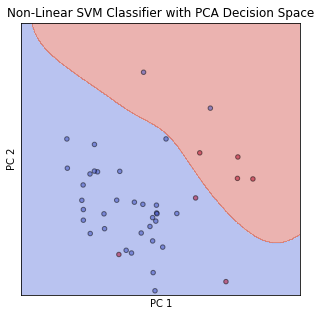

In [77]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)

## Change each classifier to see the resulting decision space
# clf = log_pca
# clf = nb_pca
# clf = linear_svm_pca
clf = rbf_svm_pca


plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.4)
ax.scatter(PC1_test, PC2_test, c = np.ravel(testing_y1), cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha = .5)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Non-Linear SVM Classifier with PCA Decision Space')

plt.show()

# Next steps: transform prediction data and predict with best models

## Use top 2 performing classifiers and compare their outputs.
#### First we needed to normalize the test (prediction) set like we did the the training and validation sets earlier.

In [79]:
norm_predict_data = new_demo_predict.drop(['index','STATE','COUNTY','CTYNAME','AGEGRP','YEAR', 'STNAME'], axis=1)
norm_predict_data[['TOT_MALE', 'TOT_FEMALE', 'BA_MALE', 'BA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'WA_MALE', 'WA_FEMALE']] = norm_predict_data[['TOT_MALE', 'TOT_FEMALE', 'BA_MALE', 'BA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE', 'WA_MALE', 'WA_FEMALE']].div(norm_predict_data.TOT_POP, axis=0)

In [80]:
norm_predict_data.head()

,TOT_POP,TOT_MALE,TOT_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,NH_MALE,NH_FEMALE,H_MALE,H_FEMALE,WA_MALE,WA_FEMALE
0,269956,0.483145,0.516855,0.095204,0.110662,0.030764,0.031839,0.433378,0.463861,0.049767,0.052994,0.340652,0.357921
1,28355,0.526080,0.473920,0.090143,0.049938,0.003209,0.003879,0.511092,0.462247,0.014989,0.011673,0.421619,0.408323
2,185287,0.496144,0.503856,0.058115,0.058682,0.009423,0.013368,0.461619,0.471317,0.034525,0.032539,0.407303,0.409721
3,27732,0.552358,0.447642,0.132122,0.068405,0.002741,0.003281,0.523475,0.433831,0.028884,0.013811,0.404551,0.362866
4,596849,0.489073,0.510927,0.051254,0.056002,0.011708,0.014696,0.436589,0.456246,0.052484,0.054680,0.409375,0.423068


### Predict with Non-linear SVM classifier

In [81]:
rbf_pred_final = rbf_svm.predict(norm_predict_data)

### Perform PCA and then predict with non-linear SVM classifier

In [82]:
norm_predict_data_pca = input_pipeline.fit_transform(norm_predict_data)

In [83]:
rbf_pred_pca_final = rbf_svm_pca.predict(norm_predict_data_pca)

In [84]:
final_predictions = pd.DataFrame(columns = ['rbf_svm','rbf_svm_pca'])
final_predictions['rbf_svm'] = rbf_pred_final
final_predictions['rbf_svm_pca'] = rbf_pred_pca_final

In [89]:
# print(final_predictions['rbf_svm_pca'].to_list())
# print(final_predictions['rbf_svm'].to_list())

# using mapping library in R to plot

### Once we have the final predictions for each classifier we wanted to have some visuals that showed the predicted outcomes with the actual county, so we use the usmap library in R to plot these visuals.

In [86]:
final_predictions      
#these are still in alphabetical order for county names

,rbf_svm,rbf_svm_pca
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,0,0
7,0,0
8,0,0
9,0,0


In [ ]:
# print(new_demo_2016['CLASS'].to_list())